In [107]:
import keras
from keras.models import Sequential
from keras.layers import Dense, InputLayer, Flatten, Conv2D, MaxPooling2D, GlobalMaxPool2D, GlobalAveragePooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.core import Activation


# Fisheries Competition

To demonstrate my understanding of the fast.ai course I'm going to try and solve the key parts of Lesson 7's fisheries challenge. 

https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/

I'm also going to use the bounding boxes that can be found: 

https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring/discussion/25902

But the first step is to understand the data:

It's setup in a nice way for keras, with the training data extracting into a set of folders, each folder containing a list of jpgs. So we can easily use the Image Data Generator from https://keras.io/preprocessing/image/


In [2]:
import os
from shutil import move , copy
from os.path import join
from os.path import split
path = join('data')
classes = os.listdir(join(path, 'train'))
classes

['.DS_Store', 'ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

Remove any hidden folders in the listing

In [3]:
classes = [c for c in classes if c[0] != '.']
classes

['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

# We need to split data into train, valid and sample. 

In [4]:
import numpy as np
from numpy.random import choice

In [5]:
import glob

valid_ratio = 0.2
num_sample_images = 10
valid_path = join(path, 'valid')
if not os.path.exists(valid_path):
    os.makedirs(valid_path)

    for c in classes:
        cl_valid_path = join(valid_path, c)
        cl_train_path = join(path, 'train', c)
        cl_sample_path = join(path, 'sample', c)
        files = glob.glob(join(cl_train_path, '*.jpg'))
        os.makedirs(cl_valid_path)
        valid = choice(files, int(np.floor(0.2*len(files))), replace=False)
        [move(v, join(cl_valid_path, split(v)[1])) for v in valid]
        # We don't want the sample to contain the validation data, so redo the glob after moving. 
        files = glob.glob(join(cl_train_path, '*.jpg'))
        os.makedirs(cl_sample_path)
        sample = choice(files, num_sample_images, replace=False)
        [copy(s, join(cl_sample_path, split(s)[1])) for s in sample]


In [6]:
classes

['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

In [7]:
os.listdir(join(path,'valid'))

['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

In [8]:
bs = 1
gen = ImageDataGenerator()
train_gen = gen.flow_from_directory(join(path,'train'), batch_size=bs, shuffle=False)
valid_gen = gen.flow_from_directory(join(path,'valid'), batch_size=bs, shuffle=False)
sample_gen = gen.flow_from_directory(join(path,'sample'), batch_size=bs, shuffle=False)


Found 3025 images belonging to 8 classes.
Found 752 images belonging to 8 classes.
Found 80 images belonging to 8 classes.


In [9]:
import bcolz
from tqdm import tqdm
import os.path

def save_generator(gen, data_dir, labels_dir):
    """
    Save the output from a generator without loading all images into memory. 
    
    Does not return anything, instead writes data to disk.
    
    :gen: A Keras ImageDataGenerator object
    :data_dir: The folder name to store the bcolz array representing the features in. 
    :labels_dir: The folder name to store the bcolz array representing the labels in.
    :mode: the write mode. Set to 'a' for append, set to 'w' to overwrite existing data and 'r' to read only. 
    
    """
    for directory in [data_dir, labels_dir]:
        if not os.path.exists(directory):
            os.makedirs(directory)
    
    num_samples = gen.samples
    
    d,l = gen.__next__()
    
    data = bcolz.carray(d, rootdir=data_dir, mode='w')
    labels = bcolz.carray(l, rootdir=labels_dir, mode='w')

    for i in tqdm(range(num_samples-1)):
        d, l = gen.__next__()
        data.append(d)
        labels.append(l)
    data.flush()
    labels.flush()


In [10]:
trn_data = join('bdat','train','data')
trn_label = join('bdat','train','label')
val_data = join('bdat','valid','data')
val_label = join('bdat','valid','label')
samp_data = join('bdat','sample','data')
samp_label = join('bdat','sample','label')

save_generator(train_gen, trn_data, trn_label)
save_generator(valid_gen, val_data, val_label)
save_generator(sample_gen, samp_data, samp_label)

data = bcolz.open(trn_data)
labels = bcolz.open(trn_label)
val_data = bcolz.open(val_data)
val_labels = bcolz.open(val_label)

100%|████████████████████████████████████| 79/79 [00:02<00:00, 38.79it/s]


In [11]:
print(data.shape)
print(labels.shape)

(3025, 256, 256, 3)
(3025, 8)


## Try the simplest model possible to check data loading, Simple Conv net. 

Let's find out the shape of the data... (actually this is the default shape due to the ImageGenerator). 

In [12]:
simple = Sequential([
    InputLayer((256,256,3)),
    Conv2D(16,(3,3), activation='relu'),
    MaxPooling2D(4),
    Conv2D(16, (3,3), activation='relu'),
    Conv2D(8, (3,3), activation='relu'),
    GlobalMaxPool2D()
  ])
simple.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 16)        2320      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 59, 59, 8)         1160      
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 8)                 0         
Total params: 3,928.0
Trainable params: 3,928.0
Non-trainable params: 0.0
_________________________________________________________________


In [13]:
simple.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
simple.fit(data, labels, batch_size=16, validation_data=(val_data,val_labels))

# Ok, lets try using a pretrained inception net. 

In [ ]:
print('blah')

In [14]:
from keras.applications.xception import Xception

xModel = Xception(include_top=False, input_shape=(256,256,3))


In [75]:
def save_predictions(model, data, rootdir, batch_size):
    """
    This function will use BColz to save the predictions from a model. This is useful when you want to get the features from a
    pretrained net and build something ontop of it without re-evaluating the network every time. 
    
    This function does not return anything and writes stuff to disk.
    
    :model: A keras model.
    :data: A Numpy dataframe, it is assumed that the first index is the batch index. 
    :roodir: The directory to store the bcolz data
    :batchsize: The number of samples to run. Will depend upon your hardware. 
    """
    output = bcolz.carray(model.predict(data[0:batch_size]), rootdir=rootdir, mode='w')
    
    for i in tqdm(range(batch_size, data.shape[0], batch_size)):
        end = i+batch_size if i+batch_size < data.shape[0] else data.shape[0]
        output.append(model.predict(data[i:end]))
    output.flush()
    

In [76]:
#os.makedirs(join('bdat','pretrained','data'))
save_predictions(xModel, data, join('bdat','pretrained','data'), 8)

100%|██████████████████████████████████| 378/378 [04:22<00:00,  1.44it/s]


In [77]:
save_predictions(xModel, val_data, join('bdat','pretrained','valdata'), 4)

100%|██████████████████████████████████| 187/187 [01:07<00:00,  2.70it/s]


In [78]:
xCdata = bcolz.open(join('bdat','pretrained','data'))
xValdata = bcolz.open(join('bdat','pretrained','valdata'))

In [87]:
pretrained_top = Sequential([
    InputLayer((8,8,2048)),
    GlobalAveragePooling2D(),
    Dense(8, activation='softmax')
])
pretrained_top.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])


In [ ]:
pretrained_top.fit(xCdata, labels, validation_data=(xValdata, val_labels))

Train on 3025 samples, validate on 752 samples
Epoch 1/10
3025/3025 [==============================] - ETA: 45s - loss: 9.4353 - acc: 0.0938 - ETA: 27s - loss: 7.6640 - acc: 0.2031 - ETA: 21s - loss: 7.6306 - acc: 0.1771 - ETA: 18s - loss: 7.2718 - acc: 0.1641 - ETA: 16s - loss: 7.1748 - acc: 0.1750 - ETA: 15s - loss: 6.9976 - acc: 0.1823 - ETA: 14s - loss: 6.6551 - acc: 0.2143 - ETA: 13s - loss: 6.3568 - acc: 0.2461

Ok, so it looks like we've gotten 77% val accuracy with this simple model. Let's try doing a fully convolutional model. 

In [108]:
conv_top = Sequential([InputLayer((8,8,2048)),
                      Conv2D(8, (3,3), padding='same', activation='relu'),
                       BatchNormalization(),
                      GlobalAveragePooling2D(),
                       Activation('softmax')
                      ])
conv_top.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

conv_top.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 8, 8, 2048)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 8, 8, 8)           147464    
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 8)           32        
_________________________________________________________________
global_average_pooling2d_8 ( (None, 8)                 0         
_________________________________________________________________
activation_3 (Activation)    (None, 8)                 0         
Total params: 147,496.0
Trainable params: 147,480.0
Non-trainable params: 16.0
_________________________________________________________________


In [109]:
conv_top.fit(xCdata, labels, validation_data=(xValdata, val_labels), batch_size=32)

Train on 3025 samples, validate on 752 samples
Epoch 1/10
3025/3025 [==============================] - ETA: 126s - loss: 1.9784 - acc: 0.2500 - ETA: 68s - loss: 2.1243 - acc: 0.2031  - ETA: 48s - loss: 2.1199 - acc: 0.2188 - ETA: 39s - loss: 2.1101 - acc: 0.2031 - ETA: 33s - loss: 2.0926 - acc: 0.1938 - ETA: 28s - loss: 2.0920 - acc: 0.1875 - ETA: 26s - loss: 2.0746 - acc: 0.2277 - ETA: 24s - loss: 2.0469 - acc: 0.2461

Cool, that got 84% validation accuracy.... 

# Ok, can we visualise the parts of the pictures that are important to this conv net? 

Jeremy constructs a function that takes in an image and returns a pixel value... this requires an end to end model... 

In [164]:
full_layers = [xModel, conv_top.layers[1]]

full_model = Sequential(full_layers)
full_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
full_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 8, 8, 2048)        20861480  
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 8, 8, 8)           147464    
Total params: 21,008,944.0
Trainable params: 20,954,416.0
Non-trainable params: 54,528.0
_________________________________________________________________


In [167]:
pred = full_model.predict(data[0][np.newaxis,:,:,:])[0]
pred.shape

(8, 8, 8)

I couldn't get Jeremy's Keras.backend.Function to work, so I've just created a new model and predicted on it. The output is the same. 
Below I'm plotting an overlay of the average pooling layer for the predicted class

In [172]:
import matplotlib.pyplot as pl
%matplotlib inline
import scipy.misc

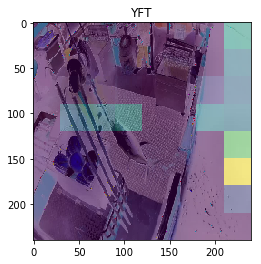

In [188]:
i = np.argmax(conv_top.predict(xCdata[0][np.newaxis,:,:,:]))
pl.figure()
pl.imshow(data[0])
pl.imshow(scipy.misc.imresize(pred[i], (240,240), interp='nearest'), alpha=0.5)
pl.title(classes[i])

It seems that the model is really using spatial cues from the image instead of actually looking for fish! 